#Hybrid Image


## Overview

A hybrid image is the sum of a *low-pass filtered* version of the one image and a *high-pass filtered* version of a second image.


In [ ]:
!pip3 install opencv-python numpy pillow matplotlib gdown
!gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
!unzip "/content/hybrid_pyramid_input.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
To: /content/hybrid_pyramid_input.zip
100% 2.19M/2.19M [00:00<00:00, 17.6MB/s]
Archive:  /content/hybrid_pyramid_input.zip
replace /content/data/Afghan_girl_before.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/motorcycle.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/cat.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/makeup_before.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/fish.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/bicycle.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/makeup_after.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/plane.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/marilyn.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/dog.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/Afghan_

## Code

In [ ]:
import cv2
import numpy as np
from scipy.signal import convolve2d

def read_image(image_path):
    """
    :param image_path: path to the image
    :return: floating representation of the image
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(float) / 255.0
    return image

def gaussian_2D_filter(size, cutoff_frequency):
    """
    :param size: tuple (width, height) that decides the filter size
    :param cutoff_frequency: hyperparameter to control the variance of the filter
    :return: 2D gaussian filter with the desired size, and variance scaled by cutoff_frequency
    """
    width, height = size
    cen_width = (width)/2
    cen_height = (height)/2

    filter = np.zeros((height,width))
    cf2 = cutoff_frequency ** 2

    for x in range(height):
      for y in range(width):
        sq_dst = (y - cen_width) ** 2 + (x - cen_height) ** 2
        filter[x, y] = np.exp(-sq_dst / (2 * cf2))

    filter /= np.sum(filter)

    return filter

def imgfilter(image, filter):
    """
    :param image: input image to apply the filter on
    :param filter: to apply on the image
    :return: apply the filter by convolving
    """
    channels = image.shape[2]
    convolved_list = []
    for ch in range(channels):
      convolved_channel = convolve2d(image[:, :, ch], filter, 'same','symm')
      convolved_list.append(convolved_channel)

    output = np.stack(convolved_list, axis=-1)
    return output

def log_mag_FFT(image):
    """
    :param image: float matrix representation of the image
    :return: log of the magnitude of the FFT of the image
    """
    image_fixed = np.clip(image * 255, 0, 255).astype(np.uint8)
    greyscale = cv2.cvtColor(image_fixed, cv2.COLOR_BGR2GRAY)

    output = np.log(np.abs(np.fft.fftshift(np.fft.fft2(greyscale))))
    ret_output = (output - np.min(output)) / (np.max(output) - np.min(output))
    return output

def vis_hybrid_image(hybrid_image):
  scales = 5
  scale_factor = 0.5
  padding = 5
  original_height = hybrid_image.shape[0]
  num_colors = hybrid_image.shape[2]
  output = hybrid_image
  cur_image = hybrid_image

  for x in range(2, scales):
      output = np.concatenate((output, np.ones((original_height, padding, num_colors), dtype=int)), axis=1)
      width = int(cur_image.shape[1] * scale_factor)
      height = int(cur_image.shape[0] * scale_factor)
      dim = (width, height)
      cur_image = cv2.resize(cur_image, dim, interpolation = cv2.INTER_LINEAR)
      tmp = np.concatenate((np.ones((original_height-cur_image.shape[0], cur_image.shape[1], num_colors)), cur_image), axis=0)
      output = np.concatenate((output, tmp), axis=1)

  output = (output * 255).astype(np.uint8)
  return output

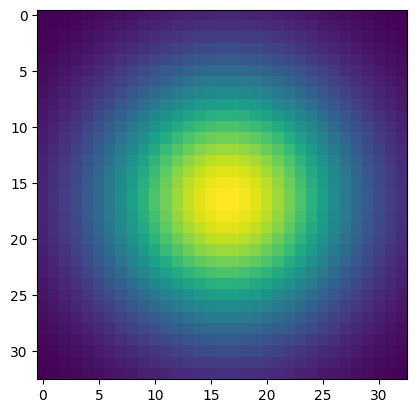

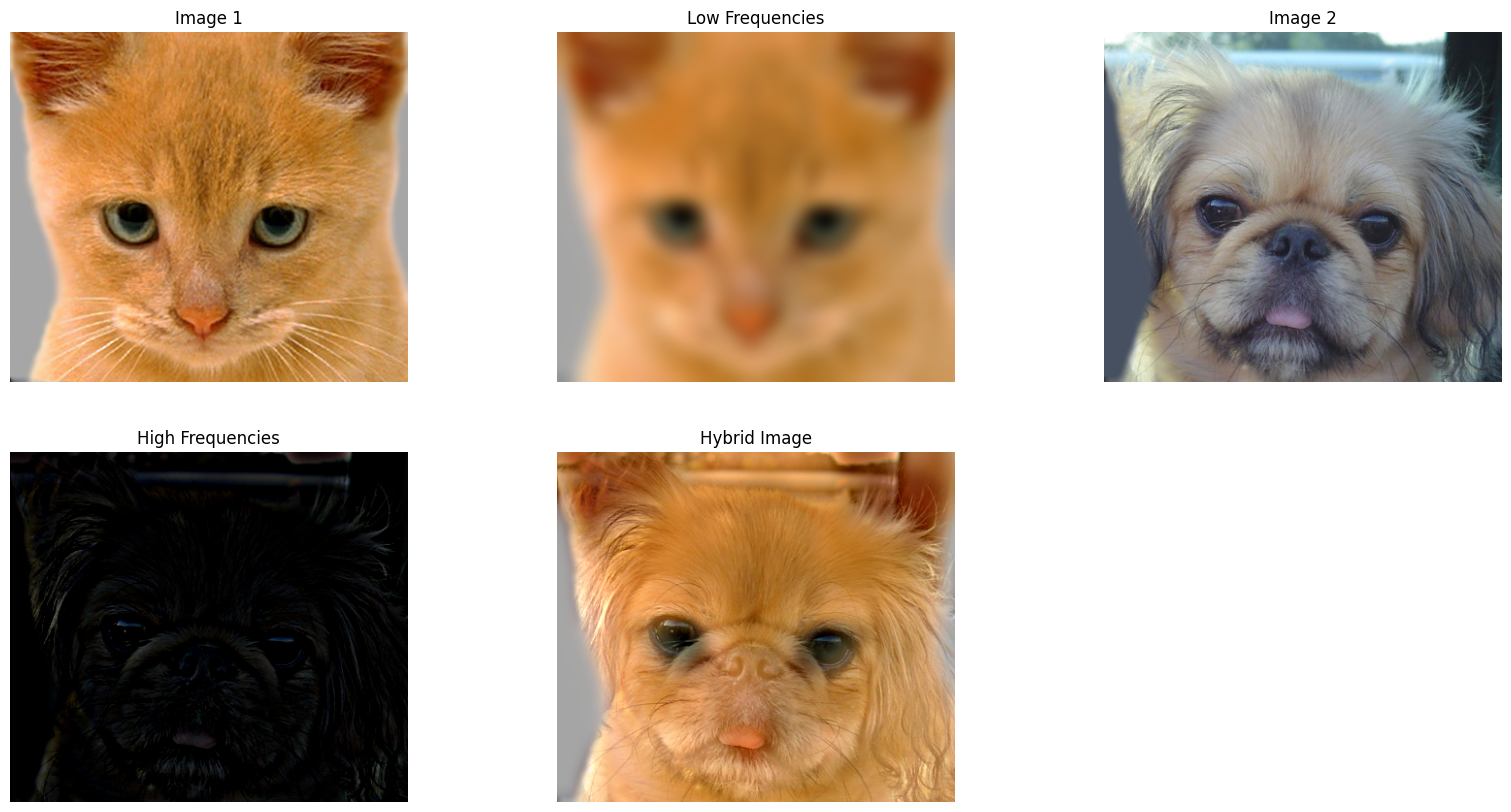

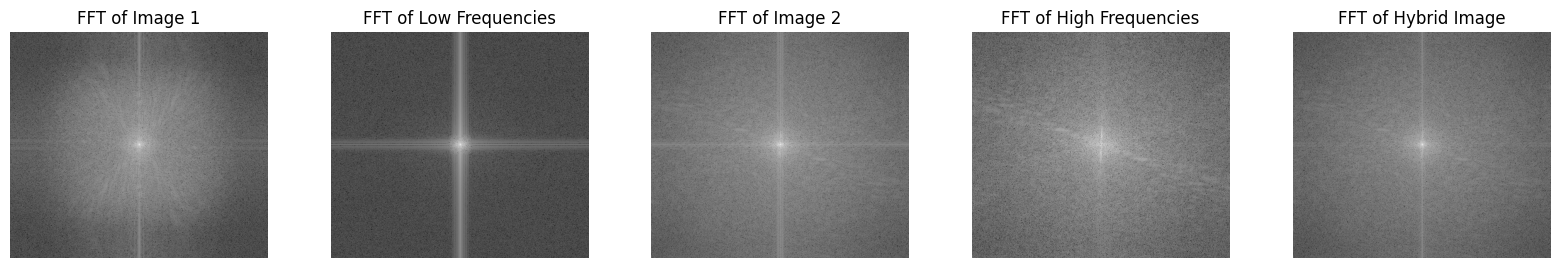

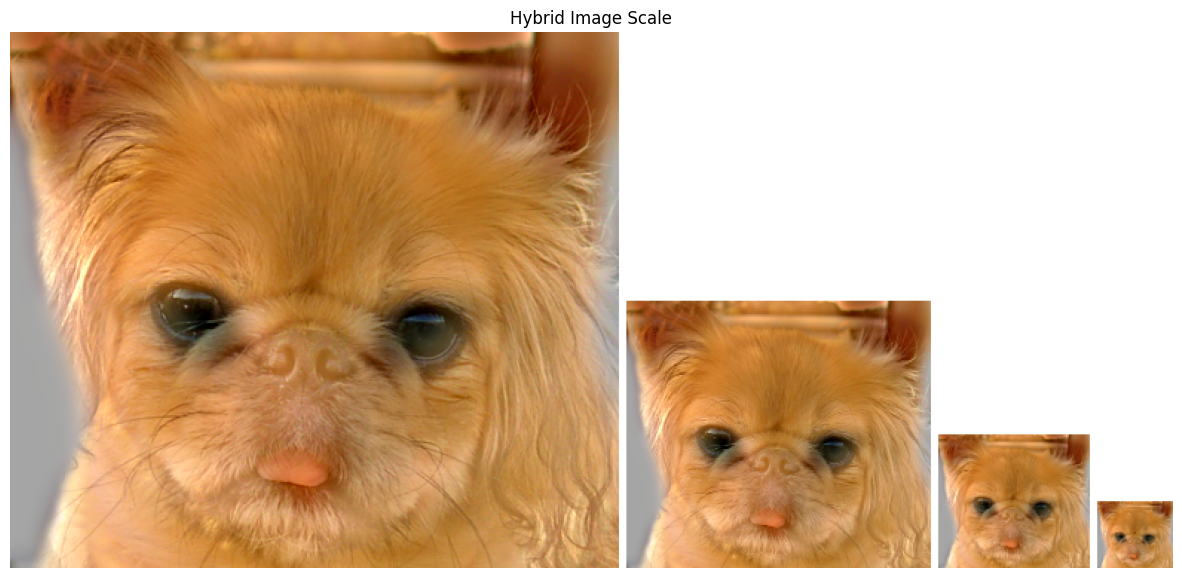

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
image_path1 = "/content/data/cat.bmp"
image_path2 = "/content/data/dog.bmp"

image_1 = read_image(image_path1)
image_2 = read_image(image_path2)

image_2 = cv2.resize(image_2, (image_1.shape[1], image_1.shape[0]))

cutoff_frequency = 8
filter_size = cutoff_frequency*4+1

"""cutoff_frequency is the standard deviation, in pixels, of the
Gaussian blur that will remove the high frequencies from one image (image_1) and
remove the low frequencies from another image (image_2)."""

filter = gaussian_2D_filter((filter_size, filter_size), cutoff_frequency)
plt.imshow(filter)

"""Use imgfilter() to create 'low_frequencies' and 'high_frequencies' and then combine them to create 'hybrid_image'."""

blurred_image1 = imgfilter(image_1, filter=filter)
blurred_image2 = imgfilter(image_2, filter=filter)

low_frequencies = blurred_image1

"""Remove the low frequencies from image_2."""

high_frequencies = image_2 - blurred_image2

"""Combine the high frequencies and low frequencies to obtain hybrid_image."""

hybrid_image= low_frequencies + high_frequencies
hybrid_image = np.clip(hybrid_image, 0, 1)

""" Visualize image_1, low_frequencies of image_1, image_2, high_frequencies of image_2, and the hybrid image."""

titles = ['Image 1', 'Low Frequencies', 'Image 2', 'High Frequencies', 'Hybrid Image']
plt.figure(figsize=(20, 10))
images = [image_1, low_frequencies, image_2, high_frequencies, hybrid_image]
for x, img in enumerate(images):
    plt.subplot(2, 3, x+1)
    plt.imshow(img, cmap='gray')
    plt.title(titles[x])
    plt.axis('off')

plt.show()

"""Log magnitude of Fourier Transform of the above."""
FFT_image = [log_mag_FFT(img) for img in images]

plt.figure(figsize=(20, 10))
for x, fft_img in enumerate(FFT_image):
    plt.subplot(3, 5, x+1)
    plt.imshow(fft_img, cmap='gray', vmin=np.min(fft_img), vmax=np.max(fft_img))
    plt.title(f'FFT of {titles[x]}')
    plt.axis('off')

plt.show()

""" Visualize hybrid_image_scale using helper function `vis_hybrid_image()`."""
hybrid_image_scale = vis_hybrid_image(hybrid_image)
plt.figure(figsize=(15, 8))
plt.imshow(hybrid_image_scale)
plt.title('Hybrid Image Scale')
plt.axis('off')
plt.show()


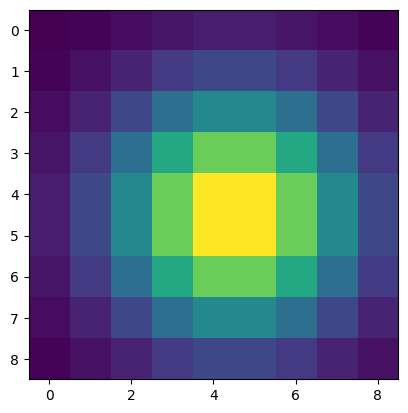

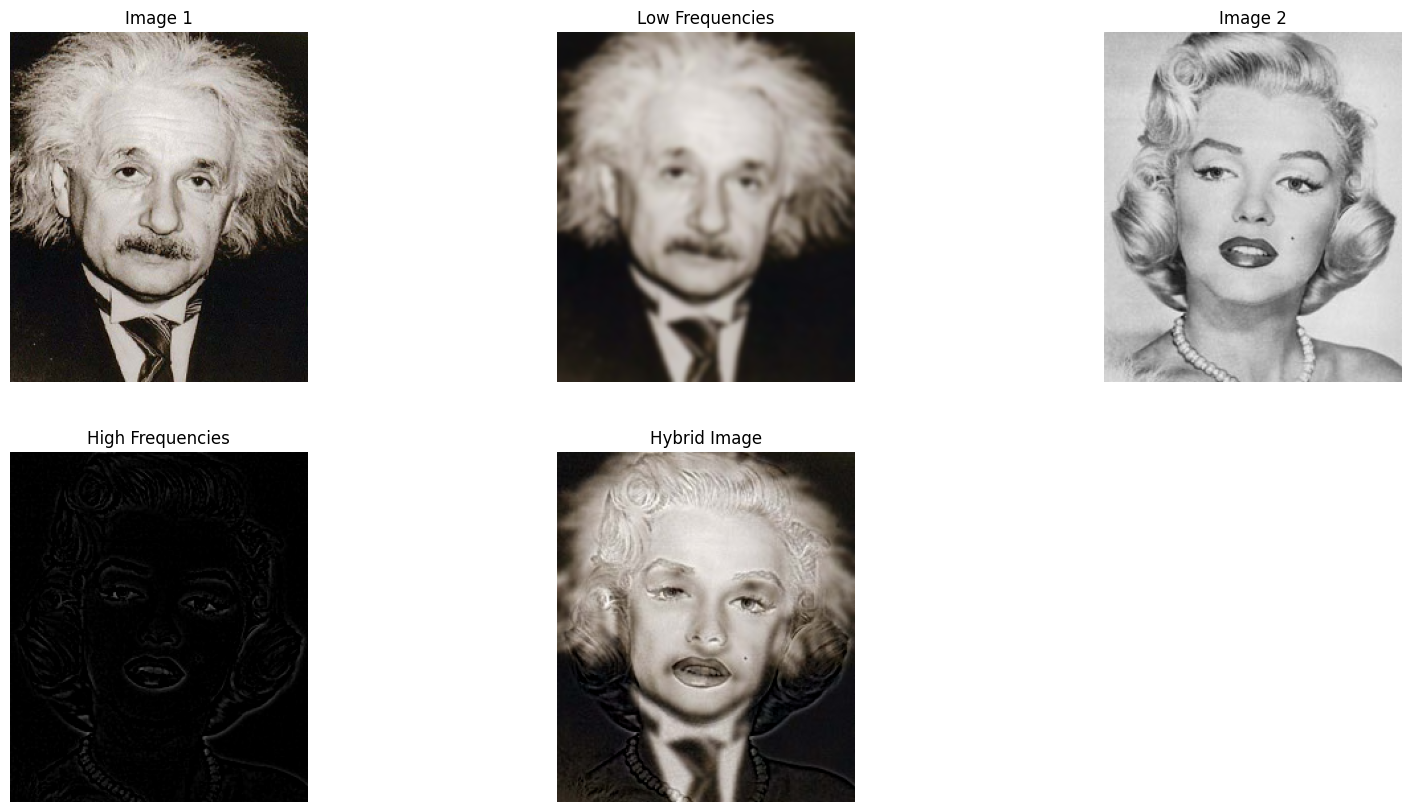

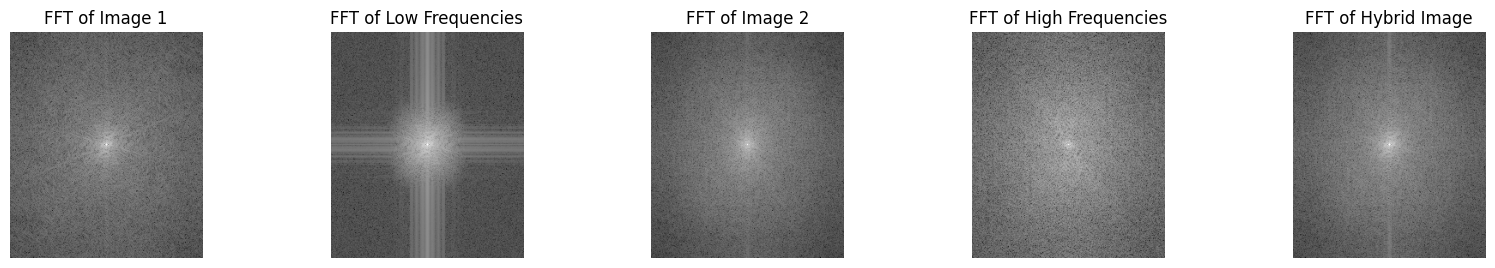

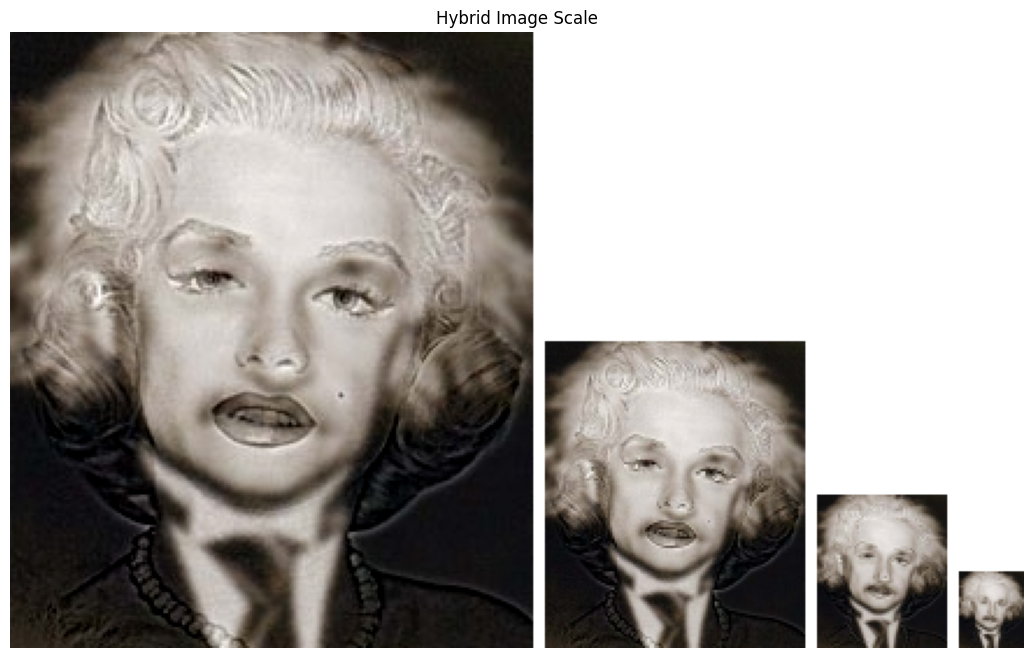

In [ ]:
image_path1 = "/content/data/einstein.bmp"
image_path2 = "/content/data/marilyn.bmp"

image_1 = read_image(image_path1)
image_2 = read_image(image_path2)

image_2 = cv2.resize(image_2, (image_1.shape[1], image_1.shape[0]))

cutoff_frequency = 2
filter_size = cutoff_frequency*4+1

filter = gaussian_2D_filter((filter_size, filter_size), cutoff_frequency)
plt.imshow(filter)

blurred_image1 = imgfilter(image_1, filter=filter)
blurred_image2 = imgfilter(image_2, filter=filter)

low_frequencies = blurred_image1

high_frequencies = image_2 - blurred_image2

hybrid_image= low_frequencies + high_frequencies
hybrid_image = np.clip(hybrid_image, 0, 1)

titles = ['Image 1', 'Low Frequencies', 'Image 2', 'High Frequencies', 'Hybrid Image']
plt.figure(figsize=(20, 10))
images = [image_1, low_frequencies, image_2, high_frequencies, hybrid_image]

for x, img in enumerate(images):
    plt.subplot(2, 3, x+1)
    plt.imshow(img, cmap='gray')
    plt.title(titles[x])
    plt.axis('off')

plt.show()

FFT_image = [log_mag_FFT(img) for img in images]

plt.figure(figsize=(20, 10))
for x, fft_img in enumerate(FFT_image):
    plt.subplot(3, 5, x+1)
    plt.imshow(fft_img, cmap='gray', vmin=np.min(fft_img), vmax=np.max(fft_img))
    plt.title(f'FFT of {titles[x]}')
    plt.axis('off')

plt.show()

hybrid_image_scale = vis_hybrid_image(hybrid_image)
plt.figure(figsize=(15, 8))
plt.imshow(hybrid_image_scale)
plt.title('Hybrid Image Scale')
plt.axis('off')
plt.show()


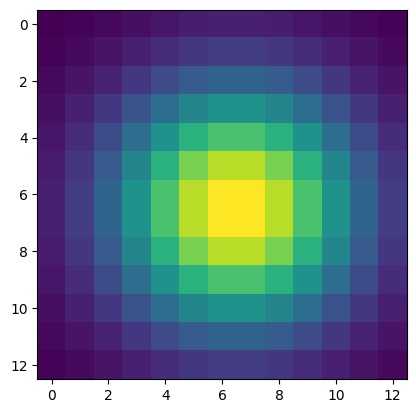

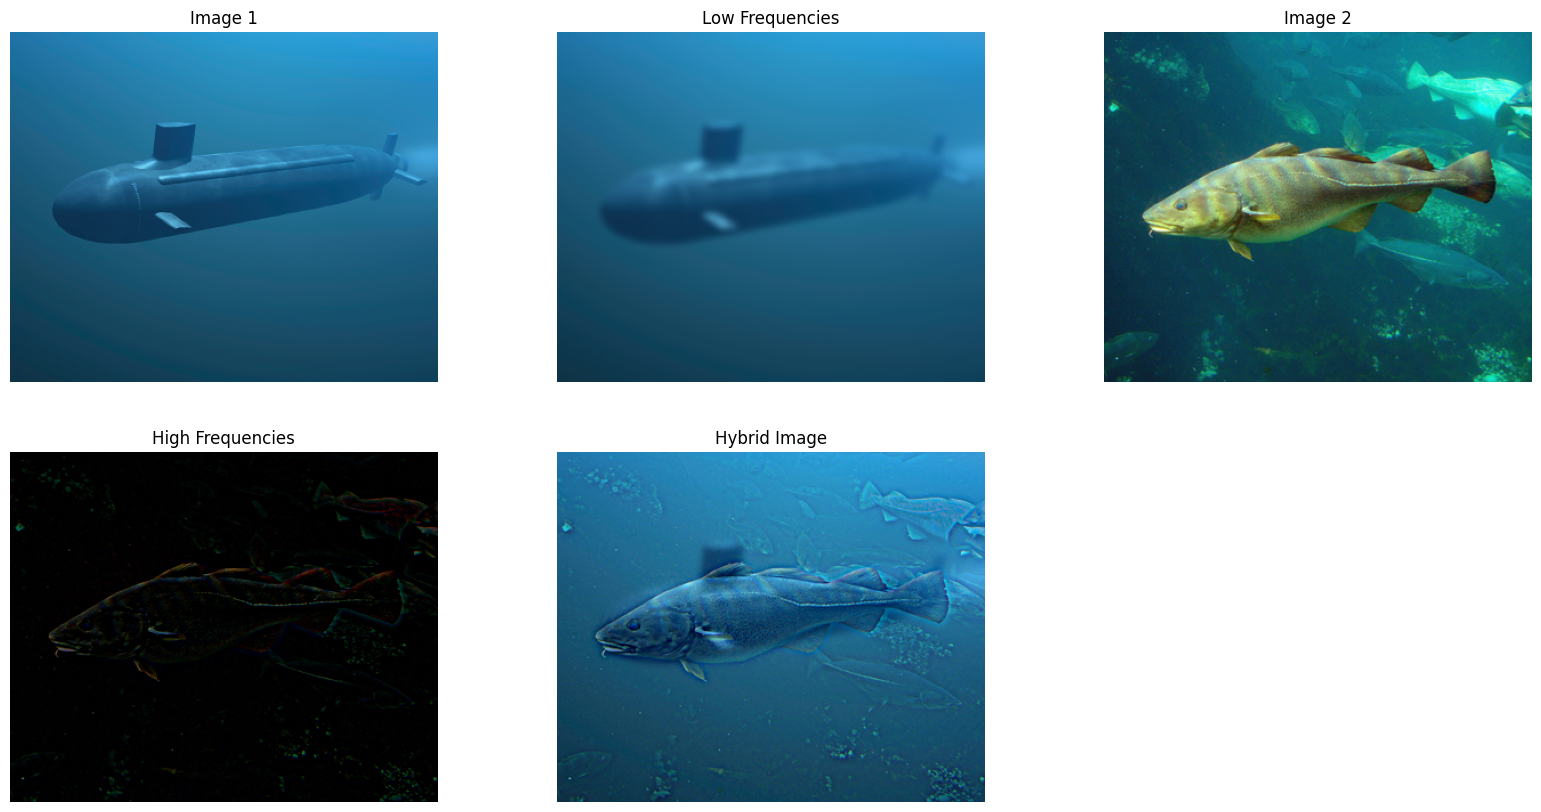

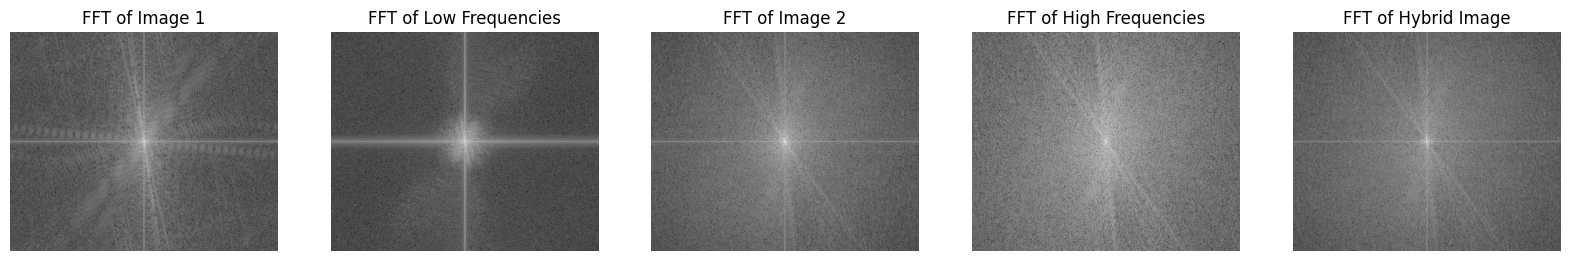

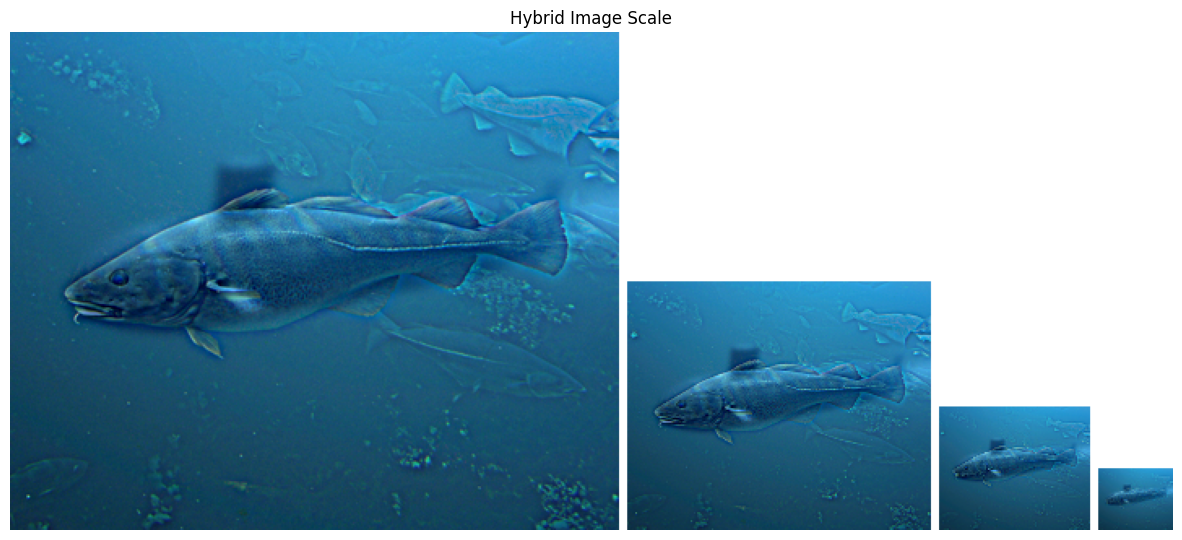

In [ ]:
image_path1 = "/content/data/submarine.bmp"
image_path2 = "/content/data/fish.bmp"


image_1 = read_image(image_path1)
image_2 = read_image(image_path2)

image_2 = cv2.resize(image_2, (image_1.shape[1], image_1.shape[0]))

cutoff_frequency = 3
filter_size = cutoff_frequency*4+1

filter = gaussian_2D_filter((filter_size, filter_size), cutoff_frequency)
plt.imshow(filter)

blurred_image1 = imgfilter(image_1, filter=filter)
blurred_image2 = imgfilter(image_2, filter=filter)

low_frequencies = blurred_image1

high_frequencies = image_2 - blurred_image2

hybrid_image= low_frequencies + high_frequencies
hybrid_image = np.clip(hybrid_image, 0, 1)

titles = ['Image 1', 'Low Frequencies', 'Image 2', 'High Frequencies', 'Hybrid Image']
plt.figure(figsize=(20, 10))
images = [image_1, low_frequencies, image_2, high_frequencies, hybrid_image]
for x, img in enumerate(images):
    plt.subplot(2, 3, x+1)
    plt.imshow(img, cmap='gray')
    plt.title(titles[x])
    plt.axis('off')

plt.show()

FFT_image = [log_mag_FFT(img) for img in images]

plt.figure(figsize=(20, 10))
for x, fft_img in enumerate(FFT_image):
    plt.subplot(3, 5, x+1)
    plt.imshow(fft_img, cmap='gray', vmin=np.min(fft_img), vmax=np.max(fft_img))
    plt.title(f'FFT of {titles[x]}')
    plt.axis('off')

plt.show()

hybrid_image_scale = vis_hybrid_image(hybrid_image)
plt.figure(figsize=(15, 8))
plt.imshow(hybrid_image_scale)
plt.title('Hybrid Image Scale')
plt.axis('off')
plt.show()


The hybrid image works because it takes one image that is filtered with the low pass filter, and combines it with another image that is filtered with a high pass filter. The low pass filter works to blur the image and remove more of the high frequency components, such as textures. The low pass filter instead keeps general shapes and colors. As illustrated in the first hybrid image generation, the cat image goes through the low pass filter and becomes blurred and less textured. In this specific project, the we use the Gaussian 2d filter in our implementation of the low and high frequency images. On the other hand, the high pass filter comes from subtracting low pass filter image from the orignal image. Finally, the hybrid image is generated by combining the low pass and high pass filtered images into a single new image. This new image combines the broad features from one image with the detailed features of another image to create an image that has two global image interpretations. As shown in the hybrid image of the first output, both a cat and dog can be perceived from that single image.



# Pyramid Image


In [ ]:
!gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
!unzip "/content/hybrid_pyramid_input.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
To: /content/hybrid_pyramid_input.zip
100% 2.19M/2.19M [00:00<00:00, 16.9MB/s]
Archive:  /content/hybrid_pyramid_input.zip
replace /content/data/Afghan_girl_before.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/motorcycle.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/cat.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/makeup_before.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/fish.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/bicycle.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/makeup_after.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/plane.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/marilyn.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/dog.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/Afghan_

## Code

In [ ]:
def pyramidsGL(image, num_levels):
  ''' Creates Gaussian (G) and Laplacian (L) pyramids of level "num_levels" from image im.
  G and L are list where G[i], L[i] stores the i-th level of Gaussian and Laplacian pyramid, respectively.'''
  G = [image]
  L = []

  for x in range(1, num_levels):
      blur_next = cv2.GaussianBlur(G[x-1], (5, 5), 0, 0)
      resized = cv2.resize(blur_next, (0,0), fx = 0.5, fy = 0.5)
      G.append(resized)

  for x in range(num_levels - 1):
      next = cv2.resize(G[x+1], (G[x].shape[1], G[x].shape[0]))
      L.append(cv2.subtract(G[x], next))

  L.append(G[-1])
  return G, L


def displayPyramids(G, L):
  '''Role of this function is to display intensity and Fast Fourier Transform (FFT) images of pyramids.'''
  num_levels = len(G)
  plt.figure(figsize=(3 * num_levels, 12))

  for x in range(num_levels):
    plt.subplot(4, num_levels, x + 1)
    plt.imshow(G[x],cmap="gray")
    plt.title(f'Gaussian Level {x} Intensity')
    plt.axis('off')

  for x in range(num_levels):
    plt.subplot(4, num_levels, num_levels + x + 1)
    plt.imshow(L[x],cmap="gray")
    plt.title(f'Laplacian Level {x} Intensity')
    plt.axis('off')

  for x in range(num_levels):
    plt.subplot(4, num_levels, 2 * num_levels + x + 1)
    fft_image = log_mag_FFT(G[x])
    plt.imshow(fft_image,cmap="gray")
    plt.title(f'FFT of Gaussian Level {x}')
    plt.axis('off')

  for x in range(num_levels - 1):
    plt.subplot(4, num_levels, 3 * num_levels + x + 1)
    fft_image = log_mag_FFT(L[x])
    plt.imshow(fft_image,cmap="gray")
    plt.title(f'FFT of Laplacian Level {x}')
    plt.axis('off')

  if len(L) > num_levels - 1:
    plt.subplot(4, num_levels, 4 * num_levels)
    fft_image = log_mag_FFT(L[-1])
    plt.imshow(fft_image,cmap="gray")
    plt.title(f'FFT of Laplacian Level {num_levels - 1}')
    plt.axis('off')

  plt.tight_layout()
  plt.show()
  return

def reconstructLaplacianPyramid(L, smallest_g):
  '''Given a Laplacian Pyramid L, reconstruct an image img.'''
  assert L[-1].shape == smallest_g.shape

  img = smallest_g
  for x in range(len(L) - 2, -1, -1):
    resize_img = cv2.resize(img, (L[x].shape[1], L[x].shape[0]))
    img = cv2.add(resize_img, L[x])

  return img


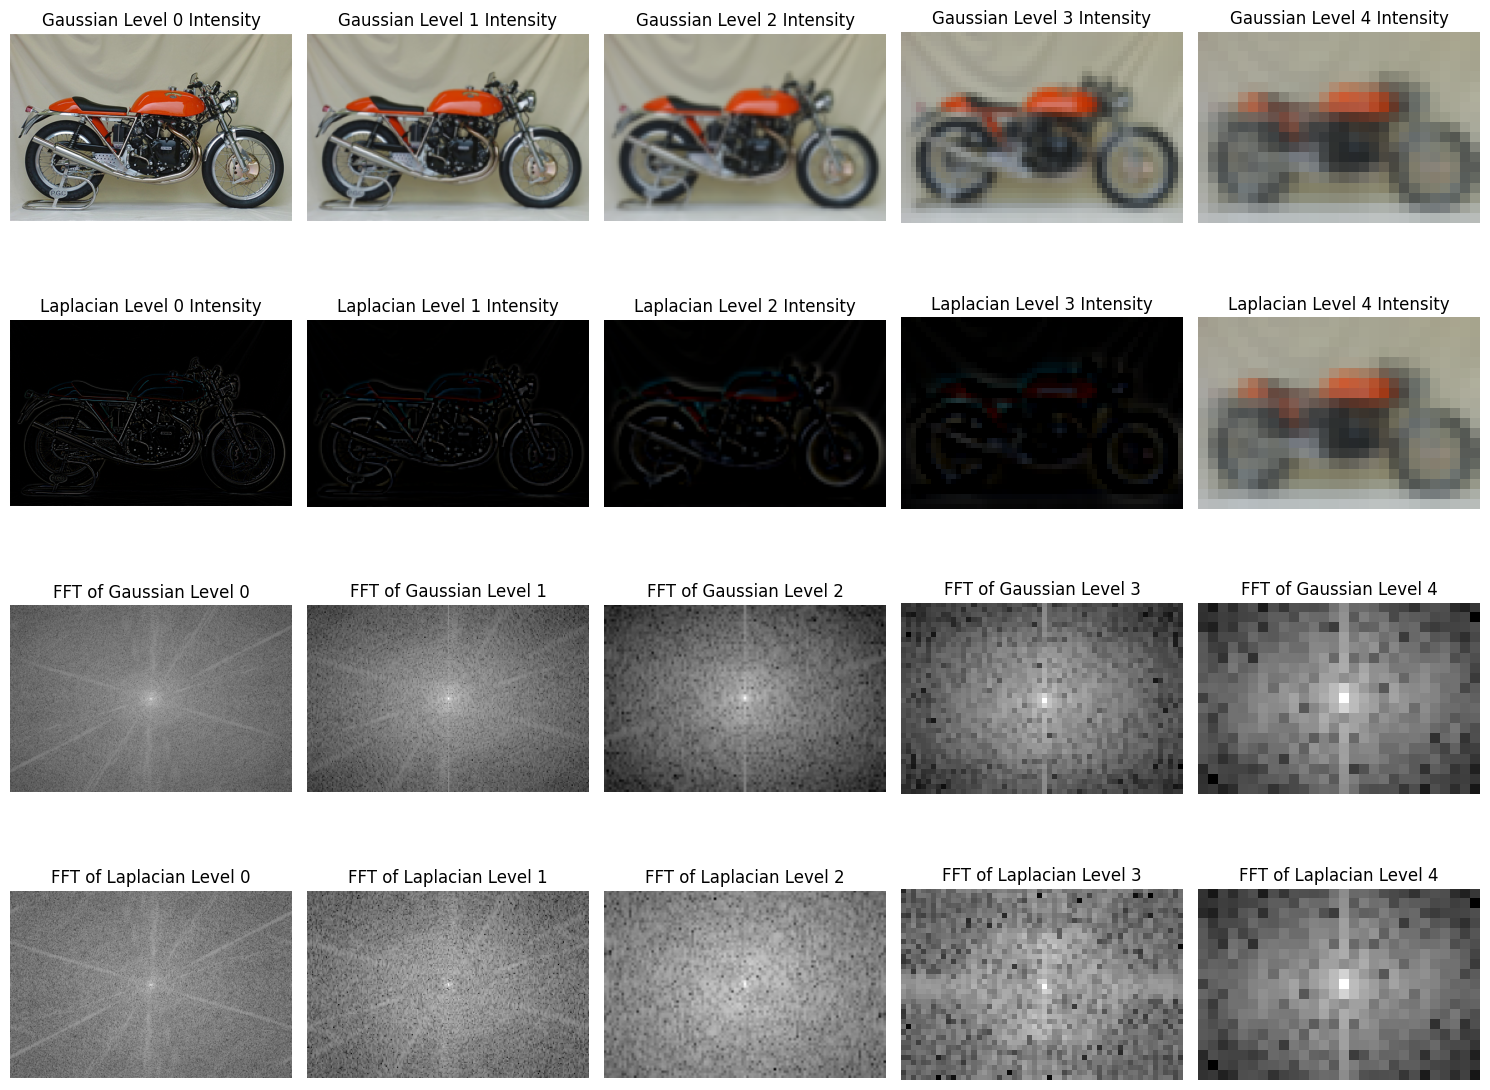

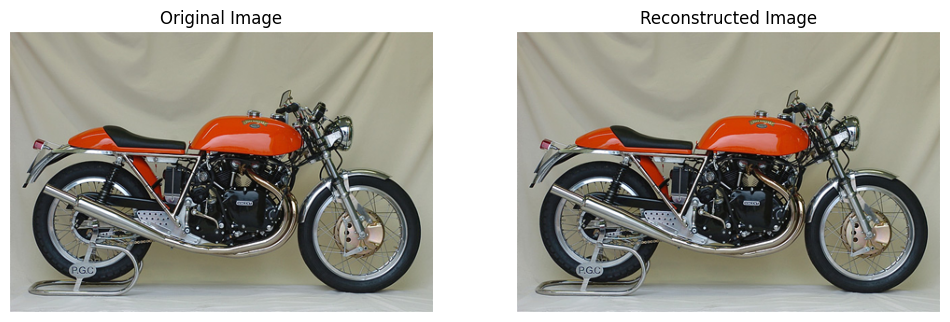

Reconstruction error (L2 norm): 1.6583718267063052e-15


In [ ]:
image_path1 = "/content/data/motorcycle.bmp"

image_1 = read_image(image_path1)
G,L = pyramidsGL(image_1,5)
displayPyramids(G,L)

reconstruct = reconstructLaplacianPyramid(L,G[-1])

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_1)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstruct)
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

error = np.sqrt(np.sum((image_1.astype("float") - reconstruct.astype("float")) ** 2))

print(f"Reconstruction error (L2 norm): {error}")





In terms of frequency, each level of the Gaussian pyramid is generated by applying the Gaussian filter to the previous image of the pyramid. Therefore, each image is a low pass filtered image of the previous level, which only contains the low frequency attributes of the previous image. Throughout each level of the pyramid the frequency is lowered and essentially becomes more blurred. On the other hand, the Laplacian Pyramid acts as an inverse to the Gaussian pyramid. It looks at the difference in frequencies between levels of the Gaussian pyramid, and uses that to generate each level of its own pyramid.In essence, it takes one blurred version of the image, compares it to the next more blurred version of the same image, finds the frequency difference between those images, and uses that difference to create an image for its own level of the pyramid.
